# GPU Benchmark Results: Condensation & Coagulation

This notebook loads benchmark results produced by
`particula/gpu/tests/benchmark_test.py` and visualizes GPU vs CPU
scaling for the two main aerosol-dynamics kernels:

* **Condensation** -- per-particle mass transfer (embarrassingly
  parallel, O(n) work).
* **Coagulation** -- stochastic particle-resolved collisions
  (sequential pair selection per box, but parallelized across boxes).

Run the benchmarks first:

```bash
pytest particula/gpu/tests/benchmark_test.py --benchmark -v -s
```

The test suite writes results to `gpu_benchmark_results.json` in the
repository root.

In [3]:
import json
from pathlib import Path

import matplotlib.pyplot as plt

## Load benchmark data

In [4]:
BENCHMARK_FILENAME = "gpu_benchmark_results.json"


def _find_benchmark_results() -> Path:
    """Walk up from cwd to find the benchmark JSON at the repo root."""
    current = Path.cwd().resolve()
    for parent in [current, *current.parents]:
        candidate = parent / BENCHMARK_FILENAME
        if candidate.exists():
            return candidate
        # Stop at the repo root (contains pyproject.toml)
        if (parent / "pyproject.toml").exists():
            break
    msg = (
        f"Could not find {BENCHMARK_FILENAME}. "
        "Run the benchmarks first:\n"
        "  pytest particula/gpu/tests/benchmark_test.py "
        "--benchmark -v -s"
    )
    raise FileNotFoundError(msg)


results_path = _find_benchmark_results()

with open(results_path) as f:
    data = json.load(f)

benchmarks = data["benchmarks"]
print(f"Loaded {len(benchmarks)} benchmark entries from {results_path}")
print(f"Run started: {data.get('started_at', 'unknown')}")

Loaded 26 benchmark entries from /home/kyle/Code/particula/gpu_benchmark_results.json
Run started: 2026-02-16T14:44:32.702909+00:00


## Condensation scaling

In [5]:
# Parse condensation entries
cond_entries = {
    k: v for k, v in benchmarks.items() if k.startswith("condensation_")
}

# Build table data
cond_rows = []
for key, entry in sorted(
    cond_entries.items(),
    key=lambda x: x[1]["n_boxes"] * x[1]["n_particles"],
):
    label = key.replace("condensation_", "")
    n_total = entry["n_boxes"] * entry["n_particles"]
    gpu_s = entry["gpu_time_s"]
    steps = entry["steps"]
    gpu_per_step = gpu_s / steps
    cpu_s = entry.get("cpu_time_s")
    speedup = entry.get("speedup")
    cond_rows.append(
        {
            "label": label,
            "n_boxes": entry["n_boxes"],
            "n_particles": entry["n_particles"],
            "total": n_total,
            "gpu_s": gpu_s,
            "gpu_per_step": gpu_per_step,
            "cpu_s": cpu_s,
            "speedup": speedup,
        }
    )

# Print table
print(
    f"{'Config':<12} {'Boxes':>5} {'Particles':>10} "
    f"{'Total':>10} {'GPU (s)':>9} {'CPU (s)':>9} {'Speedup':>8}"
)
print("-" * 75)
for r in cond_rows:
    cpu_str = f"{r['cpu_s']:.4f}" if r["cpu_s"] else "--"
    spd_str = f"{r['speedup']:.1f}x" if r["speedup"] else "--"
    print(
        f"{r['label']:<12} {r['n_boxes']:>5} {r['n_particles']:>10,} "
        f"{r['total']:>10,} {r['gpu_s']:>9.4f} {cpu_str:>9} {spd_str:>8}"
    )

Config       Boxes  Particles      Total   GPU (s)   CPU (s)  Speedup
---------------------------------------------------------------------------
1x1k             1      1,000      1,000    0.0009    0.0115    13.4x
1x10k            1     10,000     10,000    0.0008    0.1084   141.6x
10x1k           10      1,000     10,000    0.0008    0.1089   140.8x
100x1k         100      1,000    100,000    0.0008    1.0892  1407.1x
1x100k           1    100,000    100,000    0.0008        --       --
10x10k          10     10,000    100,000    0.0008        --       --
1x500k           1    500,000    500,000    0.0016        --       --
1x1M             1  1,000,000  1,000,000    0.0033        --       --
10x100k         10    100,000  1,000,000    0.0034        --       --
100x10k        100     10,000  1,000,000    0.0034        --       --
1x2M             1  2,000,000  2,000,000    0.0066        --       --
100x100k       100    100,000 10,000,000    0.0327        --       --


### Condensation GPU scaling plot

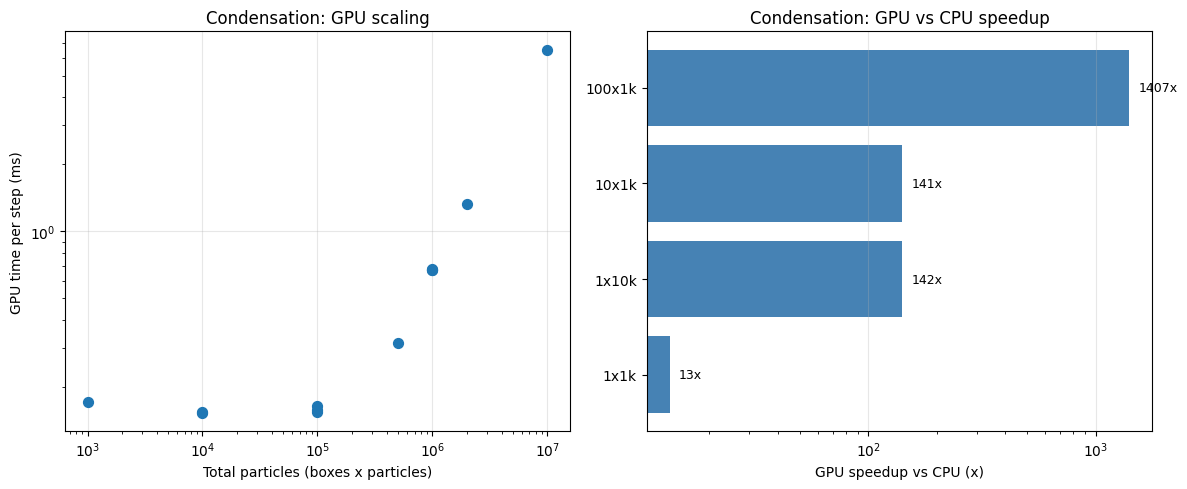

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: GPU time vs total particles
totals = [r["total"] for r in cond_rows]
gpu_times = [r["gpu_per_step"] * 1000 for r in cond_rows]  # ms
ax1.scatter(totals, gpu_times, s=50, zorder=5)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Total particles (boxes x particles)")
ax1.set_ylabel("GPU time per step (ms)")
ax1.set_title("Condensation: GPU scaling")
ax1.grid(True, alpha=0.3)

# Right: Speedup (where CPU data exists)
cpu_rows = [r for r in cond_rows if r["speedup"] is not None]
if cpu_rows:
    labels = [r["label"] for r in cpu_rows]
    speedups = [r["speedup"] for r in cpu_rows]
    bars = ax2.barh(labels, speedups, color="steelblue")
    ax2.set_xlabel("GPU speedup vs CPU (x)")
    ax2.set_title("Condensation: GPU vs CPU speedup")
    ax2.set_xscale("log")
    for bar, spd in zip(bars, speedups, strict=True):
        ax2.text(
            bar.get_width() * 1.1,
            bar.get_y() + bar.get_height() / 2,
            f"{spd:.0f}x",
            va="center",
            fontsize=9,
        )
    ax2.grid(True, alpha=0.3, axis="x")

fig.tight_layout()
plt.show()

## Coagulation scaling

In [7]:
# Parse coagulation entries
coag_entries = {
    k: v for k, v in benchmarks.items() if k.startswith("coagulation_")
}

coag_rows = []
for key, entry in sorted(
    coag_entries.items(),
    key=lambda x: x[1]["n_boxes"] * x[1]["n_particles"],
):
    label = key.replace("coagulation_", "")
    n_total = entry["n_boxes"] * entry["n_particles"]
    gpu_s = entry["gpu_time_s"]
    steps = entry["steps"]
    gpu_per_step = gpu_s / steps
    cpu_s = entry.get("cpu_time_s")
    speedup = entry.get("speedup")
    coag_rows.append(
        {
            "label": label,
            "n_boxes": entry["n_boxes"],
            "n_particles": entry["n_particles"],
            "total": n_total,
            "gpu_s": gpu_s,
            "gpu_per_step": gpu_per_step,
            "cpu_s": cpu_s,
            "speedup": speedup,
        }
    )

print(
    f"{'Config':<12} {'Boxes':>5} {'Particles':>10} "
    f"{'Total':>10} {'GPU (s)':>9} {'CPU (s)':>9} {'Speedup':>8}"
)
print("-" * 75)
for r in coag_rows:
    cpu_str = f"{r['cpu_s']:.4f}" if r["cpu_s"] else "--"
    spd_str = f"{r['speedup']:.1f}x" if r["speedup"] else "--"
    print(
        f"{r['label']:<12} {r['n_boxes']:>5} {r['n_particles']:>10,} "
        f"{r['total']:>10,} {r['gpu_s']:>9.4f} {cpu_str:>9} {spd_str:>8}"
    )

Config       Boxes  Particles      Total   GPU (s)   CPU (s)  Speedup
---------------------------------------------------------------------------
1x500            1        500        500    0.0342    0.1103     3.2x
1x2k             1      2,000      2,000    0.1354    0.3417     2.5x
1x5k             1      5,000      5,000    0.3385    0.4805     1.4x
10x500          10        500      5,000    0.0342    1.0313    30.1x
10x1k           10      1,000     10,000    0.0681    1.8371    27.0x
1x10k            1     10,000     10,000    0.6767        --       --
1x20k            1     20,000     20,000    1.3530        --       --
1x50k            1     50,000     50,000    3.3813        --       --
10x5k           10      5,000     50,000    0.3754        --       --
50x1k           50      1,000     50,000    0.0693        --       --
10x10k          10     10,000    100,000    0.6786        --       --
100x1k         100      1,000    100,000    0.0750        --       --
50x5k         

### Coagulation GPU scaling plot

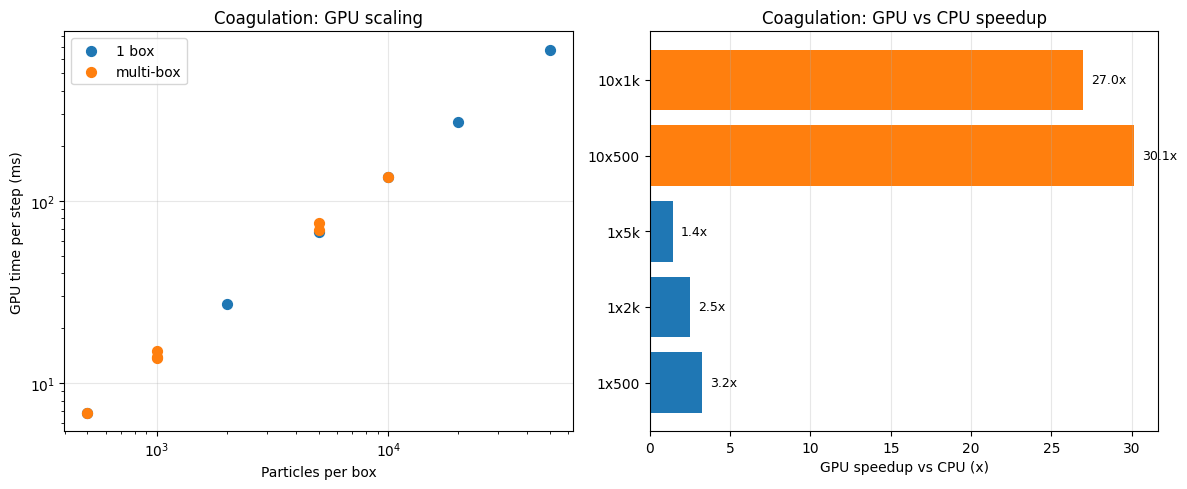

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Separate single-box vs multi-box for color coding
single_box = [r for r in coag_rows if r["n_boxes"] == 1]
multi_box = [r for r in coag_rows if r["n_boxes"] > 1]

# Left: GPU time vs particles per box (colored by n_boxes)
for rows, color, label in [
    (single_box, "tab:blue", "1 box"),
    (multi_box, "tab:orange", "multi-box"),
]:
    if rows:
        x = [r["n_particles"] for r in rows]
        y = [r["gpu_per_step"] * 1000 for r in rows]
        ax1.scatter(x, y, s=50, color=color, label=label, zorder=5)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Particles per box")
ax1.set_ylabel("GPU time per step (ms)")
ax1.set_title("Coagulation: GPU scaling")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Speedup (where CPU data exists)
cpu_rows = [r for r in coag_rows if r["speedup"] is not None]
if cpu_rows:
    labels = [r["label"] for r in cpu_rows]
    speedups = [r["speedup"] for r in cpu_rows]
    colors = [
        "tab:blue" if r["n_boxes"] == 1 else "tab:orange" for r in cpu_rows
    ]
    bars = ax2.barh(labels, speedups, color=colors)
    ax2.set_xlabel("GPU speedup vs CPU (x)")
    ax2.set_title("Coagulation: GPU vs CPU speedup")
    for bar, spd in zip(bars, speedups, strict=True):
        ax2.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            f"{spd:.1f}x",
            va="center",
            fontsize=9,
        )
    ax2.grid(True, alpha=0.3, axis="x")

fig.tight_layout()
plt.show()

## Key observations

### Condensation

* The GPU condensation kernel is **embarrassingly parallel** -- each
  particle's mass transfer is independent. This gives near-constant GPU
  time up to ~100k particles, with linear scaling beyond that.
* Speedups range from **~13x** at 1k particles to **~1,400x** at 100k
  particles per box, demonstrating excellent GPU utilization.
* At 1M particles the GPU still completes a step in under 1 ms.

### Coagulation

* The GPU coagulation kernel uses a **single thread per box** for the
  sequential acceptance-rejection pair selection loop. This means
  single-box performance is limited by the per-particle work within
  that one thread.
* **Multi-box configurations** show **25--30x** speedups because the
  GPU parallelizes across boxes.
* Single-box speedups are modest (**1.5--3x**) because the GPU thread
  does essentially the same sequential work as the CPU, just with
  faster per-operation throughput.
* The `k_max` computation uses an O(n) min/max radius bound (matching
  the CPU's bin-pair strategy) rather than the original O(n^2)
  all-pairs scan. This reduced single-box GPU time from **29s to
  0.28s** at 2k particles.

### When to use GPU acceleration

| Scenario | Recommendation |
|---|---|
| Condensation, any size | Always use GPU -- massive speedup |
| Coagulation, many boxes | Use GPU -- ~25x speedup |
| Coagulation, single box, <5k particles | Either -- modest GPU advantage |
| Coagulation, single box, >10k particles | GPU preferred for throughput |